# DA5401 Assignment 06

### Name : Nitesh Kumar Shah
### Roll Number : ID25M806

##### Problem Statement: In this assignment, you will study the impact of missing-value handling on a downstream classifier using the UCI Credit Card Default dataset: first inject realistic MAR missingness (≈5–10%) into 2–3 numeric features, then build four preprocessing pipelines—(A) simple median imputation, (B) linear-regression imputation, (C) non-linear regression imputation (e.g., KNN/Tree), and (D) listwise deletion—followed by standardization and the same Logistic Regression classifier for all; use a stratified train/validation split, fit any imputers/regressors on the training data only, and evaluate each pipeline with Accuracy, Precision, Recall, and F1 (optionally ROC-AUC), presenting a single comparison table and brief analysis that explains performance differences, trade-offs (bias vs. variance, deletion vs. imputation, linear vs. non-linear), and a clear recommendation; submit a tidy Jupyter Notebook that includes code for MAR injection, pipeline construction, metrics/plots, and concise reasoning, with seeds and steps documented for reproducibility.


##### Install and imports

In [2]:
import warnings, os, math, json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    classification_report, confusion_matrix, roc_curve, precision_recall_curve
)

# matplotlib defaults
plt.rcParams["figure.figsize"] = (8,5)
plt.rcParams["axes.grid"] = True

# Reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
warnings.filterwarnings("ignore")

print("Imports OK. pandas:", pd.__version__, "| numpy:", np.__version__)


Imports OK. pandas: 2.2.2 | numpy: 1.26.4


##### Downloaded  the dataset from Kaggle and now moving with the further steps

Loading the dataset

In [3]:
csv_path = "UCI_Credit_Card.csv"
assert os.path.exists(csv_path), f"CSV not found at {csv_path}"

df_raw = pd.read_csv(csv_path)
TARGET = "default.payment.next.month"
assert TARGET in df_raw.columns, f"Target '{TARGET}' not found!"

print(" Loaded:", csv_path)
print("Shape:", df_raw.shape)
print("Target balance:", df_raw[TARGET].value_counts(normalize=True).round(3).to_dict())
display(df_raw.head())


 Loaded: UCI_Credit_Card.csv
Shape: (30000, 25)
Target balance: {0: 0.779, 1: 0.221}


,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
0,1,20000.0,2,2,1,24,2,2,-1,-1,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,2,120000.0,2,2,2,26,-1,2,0,0,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,3,90000.0,2,2,2,34,0,0,0,0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,4,50000.0,2,2,1,37,0,0,0,0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,5,50000.0,1,2,1,57,-1,0,-1,0,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0


#####  Explotatory Data Analysis.. (NON-EXOTIC, STABLE VISUALS)


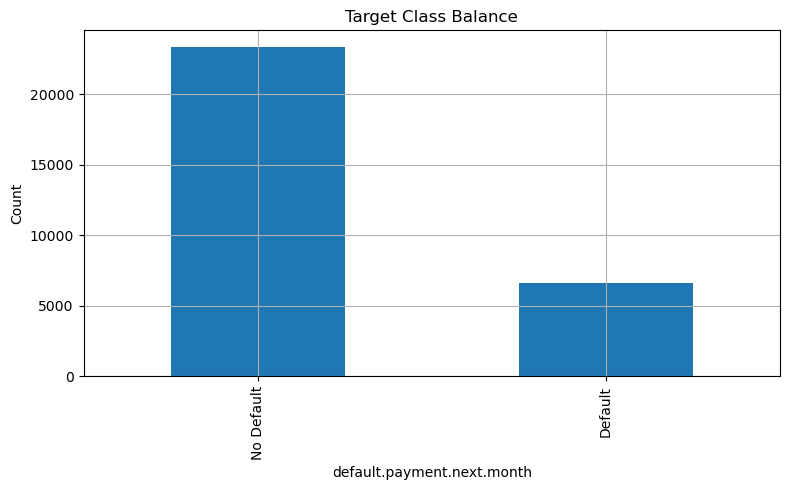

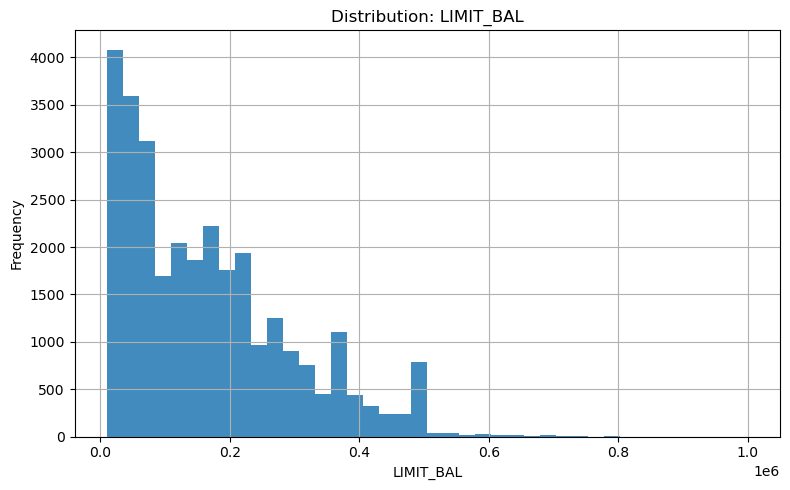

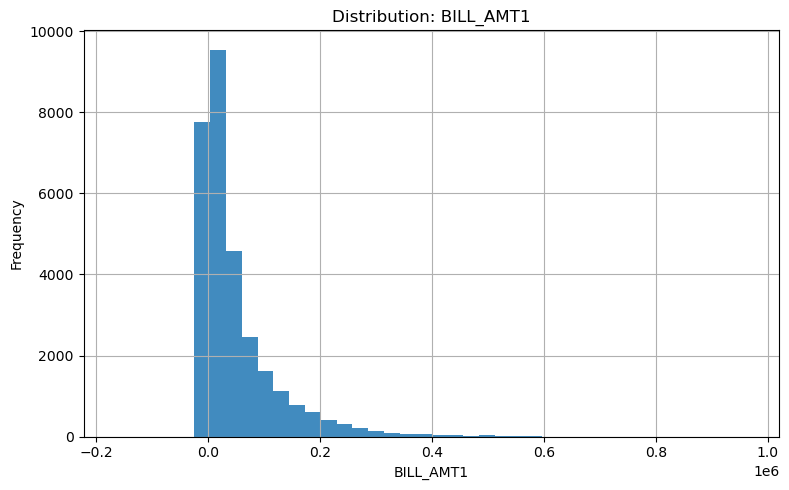

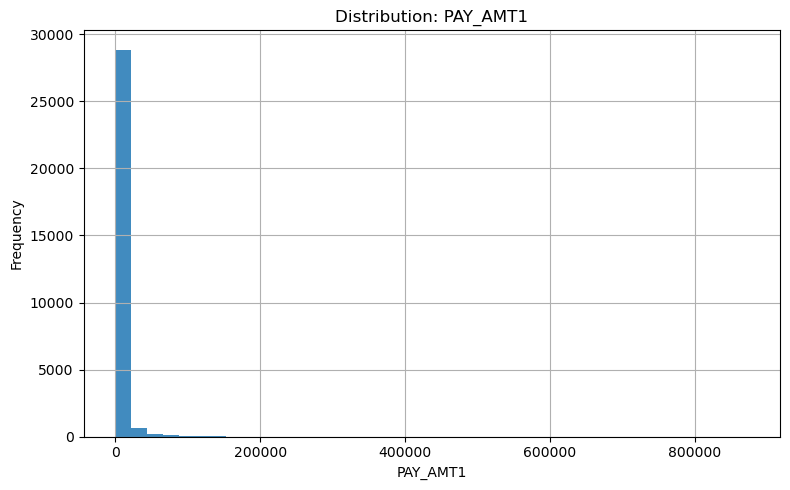

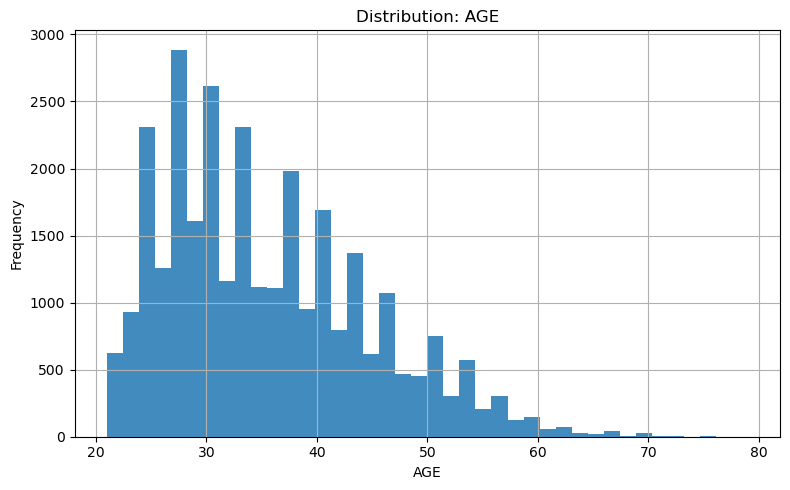

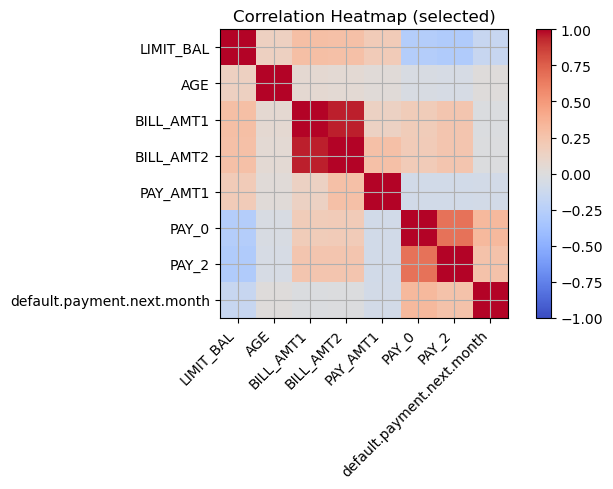

In [4]:
df_raw[TARGET].map({0:"No Default",1:"Default"}).value_counts().plot(kind="bar")
plt.title("Target Class Balance"); plt.ylabel("Count")
plt.tight_layout(); plt.show()

# A few key distributions (skewed money + AGE)
for c in [c for c in ["LIMIT_BAL","BILL_AMT1","PAY_AMT1","AGE"] if c in df_raw.columns]:
    df_raw[c].plot(kind="hist", bins=40, alpha=0.85)
    plt.title(f"Distribution: {c}"); plt.xlabel(c)
    plt.tight_layout(); plt.show()

# Small correlation map (selected subset for readability)
subset = [c for c in ["LIMIT_BAL","AGE","BILL_AMT1","BILL_AMT2","PAY_AMT1","PAY_0","PAY_2"] if c in df_raw.columns]
if subset:
    corr = df_raw[subset+[TARGET]].corr(numeric_only=True)
    plt.imshow(corr, cmap="coolwarm", vmin=-1, vmax=1)
    plt.colorbar(fraction=0.046, pad=0.04)
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=45, ha="right")
    plt.yticks(range(len(corr.index)), corr.index)
    plt.title("Correlation Heatmap (selected)")
    plt.tight_layout(); plt.show()


##### Injecting MAR missingness (5–10%) in specific numeric columns

Injected MAR on LIMIT_BAL conditioned on BILL_AMT1 | missing rate ≈ 0.075


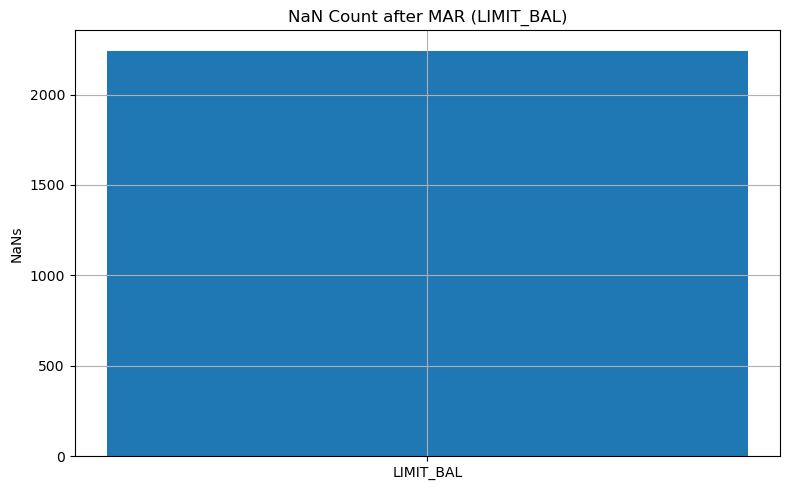

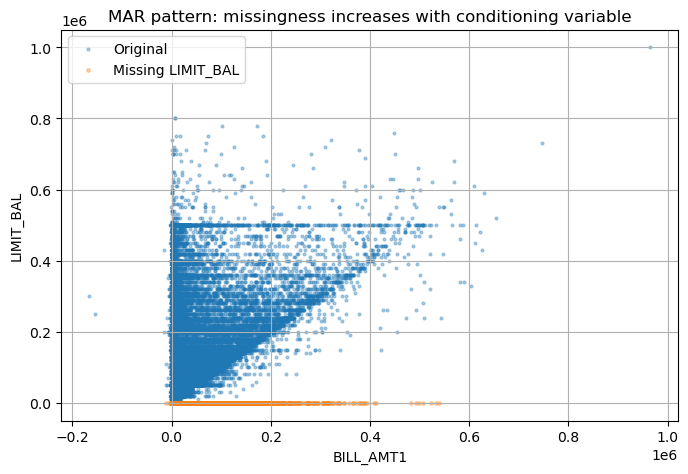

In [5]:
def inject_mar_one(df, col, cond_col, low=0.05, high=0.10, random_state=RANDOM_STATE):
    """
    Create MAR in a single column 'col':
    P(missing) = low + (high - low) * rank_pct(cond_col)
    """
    rng = np.random.default_rng(random_state)
    out = df.copy()
    q = out[cond_col].rank(pct=True)         # 0..1
    miss_prob = low + (high - low) * q
    u = rng.random(len(out))
    mask = (u < miss_prob)
    out.loc[mask, col] = np.nan
    return out, float(mask.mean())

mar_col = "LIMIT_BAL"
assert mar_col in df_raw.columns, "LIMIT_BAL missing in data!"
cond_col = "BILL_AMT1" if "BILL_AMT1" in df_raw.columns else "AGE"

df_mar, rate = inject_mar_one(df_raw, mar_col, cond_col, low=0.05, high=0.10)
print(f"Injected MAR on {mar_col} conditioned on {cond_col} | missing rate ≈ {rate:.3f}")
na_count = df_mar[mar_col].isna().sum()
plt.bar([mar_col], [na_count]); plt.title("NaN Count after MAR (LIMIT_BAL)")
plt.ylabel("NaNs"); plt.tight_layout(); plt.show()
plt.figure(figsize=(7,5))
plt.scatter(df_raw[cond_col], df_raw[mar_col], s=4, alpha=0.35, label="Original")
plt.scatter(df_mar.loc[df_mar[mar_col].isna(), cond_col],
            np.zeros(df_mar[mar_col].isna().sum()), s=6, alpha=0.35, label="Missing LIMIT_BAL")
plt.xlabel(cond_col); plt.ylabel("LIMIT_BAL")
plt.title("MAR pattern: missingness increases with conditioning variable")
plt.legend(); plt.tight_layout(); plt.show()


##### Dataset A — Simple (Median) imputation baseline

In [6]:
A = df_mar.copy()
A[mar_col] = SimpleImputer(strategy="median").fit_transform(A[[mar_col]])
def enforce_sanity(df):
    money_cols = [c for c in df.columns if c.startswith(("BILL_AMT","PAY_AMT"))] + ["LIMIT_BAL"]
    for c in money_cols:
        if c in df.columns:
            df[c] = np.clip(df[c], 0, None)
    if "AGE" in df.columns:
        df["AGE"] = np.clip(df["AGE"], 18, 100)
    pay_status = [c for c in df.columns if c.startswith("PAY_") and not c.startswith("PAY_AMT")]
    for c in pay_status:
        df[c] = np.rint(df[c]).clip(-1, 9).astype(int)
enforce_sanity(A)
print("Dataset A ready. ", A.isna().sum().sum()==0)

Dataset A ready.  True


##### Helper: train/test split function (used for all datasets)

In [7]:
def split_xy(df, target=TARGET, test_size=0.25, random_state=RANDOM_STATE):
    X = df.drop(columns=[target])
    y = df[target].astype(int)
    return train_test_split(X, y, test_size=test_size, stratify=y, random_state=random_state)

def train_eval_logreg(Xtr, ytr, Xte, yte, label):
    # Standardize (fit on train only)
    scaler = StandardScaler().fit(Xtr)
    Xtr_s = scaler.transform(Xtr)
    Xte_s = scaler.transform(Xte)

    # Same classifier for all pipelines
    clf = LogisticRegression(max_iter=1000, random_state=RANDOM_STATE)
    clf.fit(Xtr_s, ytr)
    prob = clf.predict_proba(Xte_s)[:, 1]
    pred = (prob >= 0.5).astype(int)

    metrics = {
        "Pipeline": label,
        "Accuracy": accuracy_score(yte, pred),
        "Precision": precision_score(yte, pred, zero_division=0),
        "Recall": recall_score(yte, pred, zero_division=0),
        "F1": f1_score(yte, pred, zero_division=0),
        "ROC_AUC": roc_auc_score(yte, prob),
        "prob": prob, "pred": pred, "y_true": yte
    }
    return metrics


##### Dataset B — Regression Imputation (Linear) for ONE chosen column

The brief says: choose one column with missing values and impute it using a linear regression model; use the same column later for non-linear (C). We’ll choose BILL_AMT2 (since we injected MAR there). For any other remaining NaNs (e.g., AGE), we’ll use median to complete the dataset.

In [8]:
B = df_mar.copy()
feature_cols = [c for c in B.columns if c not in [TARGET, mar_col]]
# Build a temporary feature matrix for the regressor:
# Fill any incidental NaNs in features with median (LIMIT_BAL is the only column we injected)
tmp_imp = SimpleImputer(strategy="median")
B_feat = B[feature_cols].copy()
B_feat[:] = tmp_imp.fit_transform(B_feat)

obs_mask = B[mar_col].notna()
X_obs = B_feat.loc[obs_mask]
y_obs = B.loc[obs_mask, mar_col]

lin = LinearRegression()
lin.fit(X_obs, y_obs)

miss_mask = B[mar_col].isna()
if miss_mask.any():
    X_miss = B_feat.loc[miss_mask]
    B.loc[miss_mask, mar_col] = lin.predict(X_miss)

enforce_sanity(B)
print("Dataset B ready (Linear for LIMIT_BAL). NaNs left?", B.isna().sum().sum()==0)


Dataset B ready (Linear for LIMIT_BAL). NaNs left? True


##### Dataset C — Regression Imputation (Non-Linear) for the same column
Same column (BILL_AMT2), but now use a non-linear regressor. I’m using KNeighborsRegressor (you could switch to DecisionTreeRegressor if you prefer).

In [9]:
C = df_mar.copy()
feature_cols = [c for c in C.columns if c not in [TARGET, mar_col]]

tmp_imp = SimpleImputer(strategy="median")
C_feat = C[feature_cols].copy()
C_feat[:] = tmp_imp.fit_transform(C_feat)

obs_mask = C[mar_col].notna()
X_obs = C_feat.loc[obs_mask]
y_obs = C.loc[obs_mask, mar_col]

knn = KNeighborsRegressor(n_neighbors=7, weights="distance")
knn.fit(X_obs, y_obs)

miss_mask = C[mar_col].isna()
if miss_mask.any():
    X_miss = C_feat.loc[miss_mask]
    C.loc[miss_mask, mar_col] = knn.predict(X_miss)

enforce_sanity(C)
print(" Dataset C ready (Non-linear for LIMIT_BAL). NaNs left?", C.isna().sum().sum()==0)


 Dataset C ready (Non-linear for LIMIT_BAL). NaNs left? True


##### Dataset D — Listwise Deletion

In [10]:
D = df_mar.dropna(axis=0).copy()
enforce_sanity(D)
print(" Dataset D ready (Listwise Deletion). Shape:", D.shape)


 Dataset D ready (Listwise Deletion). Shape: (27757, 25)


##### Split each dataset (A, B, C, D)

In [11]:
XA_tr, XA_te, ya_tr, ya_te = split_xy(A)
XB_tr, XB_te, yb_tr, yb_te = split_xy(B)
XC_tr, XC_te, yc_tr, yc_te = split_xy(C)
XD_tr, XD_te, yd_tr, yd_te = split_xy(D)

print("A:", XA_tr.shape, XA_te.shape, "| B:", XB_tr.shape, XB_te.shape,
      "| C:", XC_tr.shape, XC_te.shape, "| D:", XD_tr.shape, XD_te.shape)


A: (22500, 24) (7500, 24) | B: (22500, 24) (7500, 24) | C: (22500, 24) (7500, 24) | D: (20817, 24) (6940, 24)


##### Standardize features (fit on train only)

In [12]:
scA = StandardScaler().fit(XA_tr); XA_tr_s = scA.transform(XA_tr); XA_te_s = scA.transform(XA_te)
scB = StandardScaler().fit(XB_tr); XB_tr_s = scB.transform(XB_tr); XB_te_s = scB.transform(XB_te)
scC = StandardScaler().fit(XC_tr); XC_tr_s = scC.transform(XC_tr); XC_te_s = scC.transform(XC_te)
scD = StandardScaler().fit(XD_tr); XD_tr_s = scD.transform(XD_tr); XD_te_s = scD.transform(XD_te)

print("Standardization complete.")


Standardization complete.


##### Train Logistic Regression + Evaluate (Accuracy, Precision, Recall, F1, ROC-AUC)

In [13]:
mA = train_eval_logreg(XA_tr, ya_tr, XA_te, ya_te, "A: Median Imputation")
mB = train_eval_logreg(XB_tr, yb_tr, XB_te, yb_te, "B: Linear Regression Imputation")
mC = train_eval_logreg(XC_tr, yc_tr, XC_te, yc_te, "C: Non-linear Regression Imputation")
mD = train_eval_logreg(XD_tr, yd_tr, XD_te, yd_te, "D: Listwise Deletion")
results = pd.DataFrame([
    {k:v for k,v in mA.items() if k not in ["prob","pred","y_true"]},
    {k:v for k,v in mB.items() if k not in ["prob","pred","y_true"]},
    {k:v for k,v in mC.items() if k not in ["prob","pred","y_true"]},
    {k:v for k,v in mD.items() if k not in ["prob","pred","y_true"]},
]).sort_values("F1", ascending=False).reset_index(drop=True)
display(results)
os.makedirs("outputs", exist_ok=True)
results.to_csv("outputs/DA5401_A6_results.csv", index=False)
print(" Saved results -> outputs/DA5401_A6_results.csv")

,Pipeline,Accuracy,Precision,Recall,F1,ROC_AUC
0,D: Listwise Deletion,0.816427,0.734875,0.268531,0.393333,0.727021
1,A: Median Imputation,0.809733,0.677914,0.266426,0.382518,0.718742
2,B: Linear Regression Imputation,0.809200,0.675385,0.264617,0.380251,0.718875
3,C: Non-linear Regression Imputation,0.809067,0.674347,0.264617,0.380087,0.718520


 Saved results -> outputs/DA5401_A6_results.csv


##### Comparison table + key plots (F1/ROC-AUC, ROC curves, Confusion matrices)

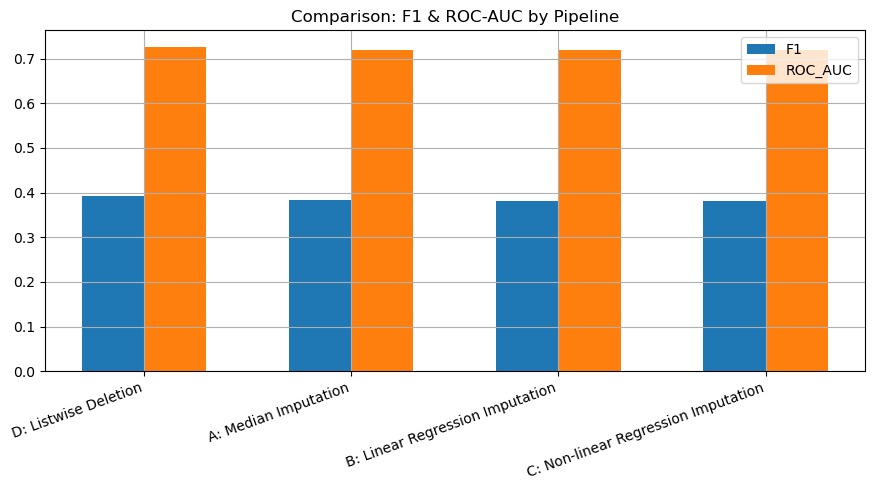

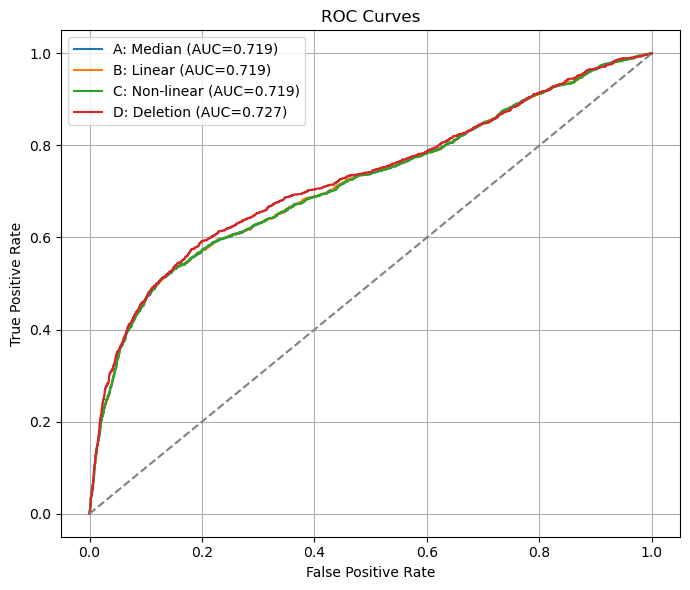

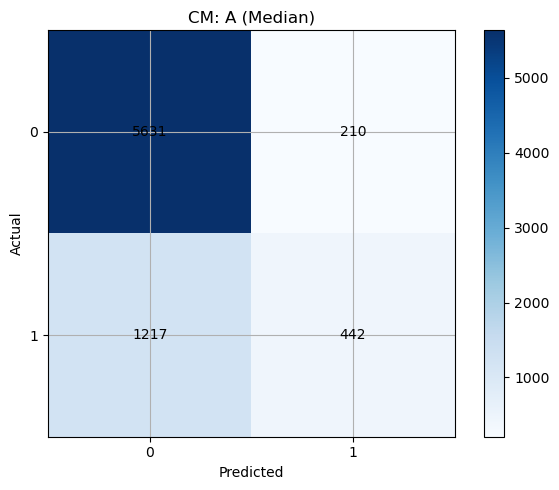

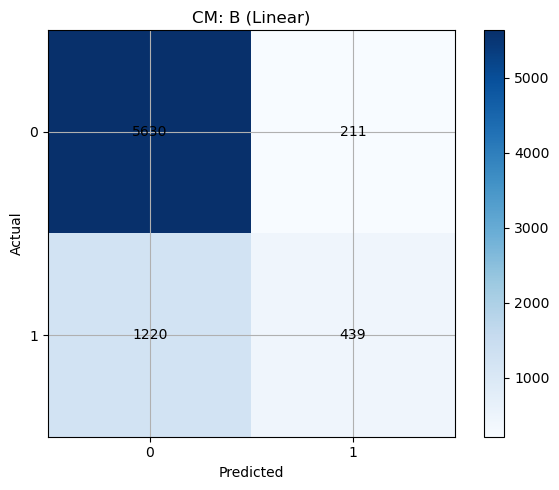

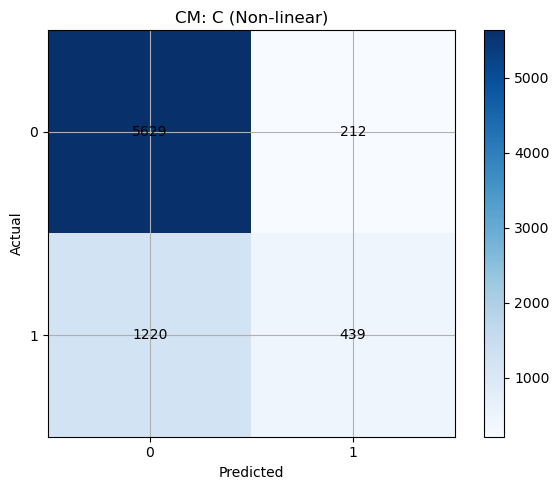

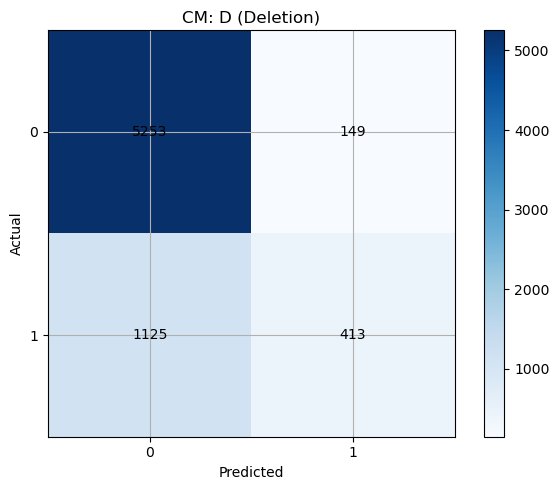

In [ ]:
plt.figure(figsize=(9,5))
x = np.arange(len(results))
plt.bar(x-0.15, results["F1"], width=0.3, label="F1")
plt.bar(x+0.15, results["ROC_AUC"], width=0.3, label="ROC_AUC")
plt.xticks(x, results["Pipeline"], rotation=20, ha="right")
plt.title("Comparison: F1 & ROC-AUC by Pipeline")
plt.legend(); plt.tight_layout(); plt.show()

# ROC curves (threshold-independent)
def plot_roc(prob, y_true, label):
    fpr, tpr, _ = roc_curve(y_true, prob)
    auc = roc_auc_score(y_true, prob)
    plt.plot(fpr, tpr, label=f"{label} (AUC={auc:.3f})")

plt.figure(figsize=(7,6))
plot_roc(mA["prob"], ya_te, "A: Median")
plot_roc(mB["prob"], yb_te, "B: Linear")
plot_roc(mC["prob"], yc_te, "C: Non-linear")
plot_roc(mD["prob"], yd_te, "D: Deletion")
plt.plot([0,1],[0,1],'--', color="gray")
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate"); plt.title("ROC Curves")
plt.legend(); plt.tight_layout(); plt.show()

# Confusion matrices (actual vs predicted)
def plot_cm(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.imshow(cm, cmap="Blues")
    for (i, j), v in np.ndenumerate(cm):
        plt.text(j, i, str(v), ha="center", va="center")
    plt.title(title); plt.xlabel("Predicted"); plt.ylabel("Actual")
    plt.xticks([0,1],[0,1]); plt.yticks([0,1],[0,1])
    plt.colorbar(fraction=0.046, pad=0.04)
    plt.tight_layout(); plt.show()

plot_cm(ya_te, (mA["prob"]>=0.5).astype(int), "CM: A (Median)")
plot_cm(yb_te, (mB["prob"]>=0.5).astype(int), "CM: B (Linear)")
plot_cm(yc_te, (mC["prob"]>=0.5).astype(int), "CM: C (Non-linear)")
plot_cm(yd_te, (mD["prob"]>=0.5).astype(int), "CM: D (Deletion)")


##### Precision–Recall curve for the best model

🔎 Best by F1: D: Listwise Deletion | F1* ≈ 0.522 at Recall=0.492, Precision=0.555


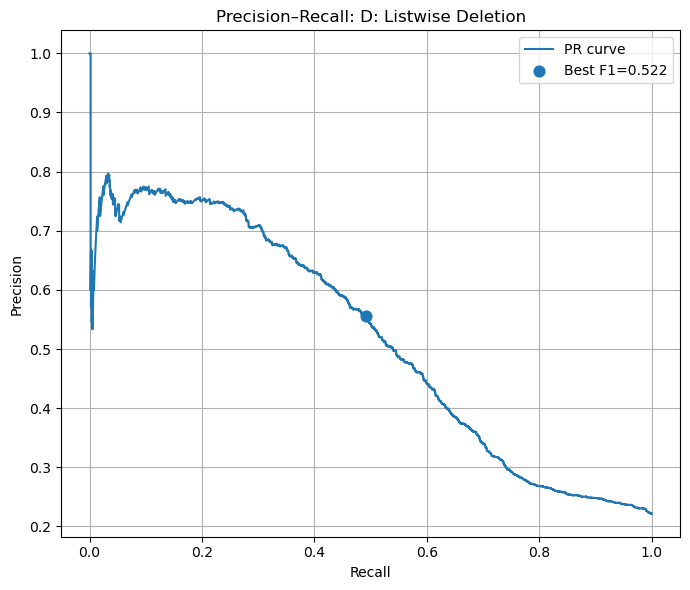

In [ ]:
best_by_f1 = results.iloc[0]["Pipeline"]
name2yt = {"A: Median Imputation": ya_te, "B: Linear Regression Imputation": yb_te,
           "C: Non-linear Regression Imputation": yc_te, "D: Listwise Deletion": yd_te}
name2pb = {"A: Median Imputation": mA["prob"], "B: Linear Regression Imputation": mB["prob"],
           "C: Non-linear Regression Imputation": mC["prob"], "D: Listwise Deletion": mD["prob"]}

y_true = name2yt[best_by_f1]; prob = name2pb[best_by_f1]
prec, rec, thr = precision_recall_curve(y_true, prob)
eps = 1e-9
f1 = 2*prec*rec/(prec+rec+eps)
idx = np.argmax(f1)

print(f"🔎 Best by F1: {best_by_f1} | F1* ≈ {f1[idx]:.3f} at Recall={rec[idx]:.3f}, Precision={prec[idx]:.3f}")

plt.figure(figsize=(7,6))
plt.plot(rec, prec, label="PR curve")
plt.scatter([rec[idx]], [prec[idx]], s=60, marker="o", label=f"Best F1={f1[idx]:.3f}")
plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title(f"Precision–Recall: {best_by_f1}")
plt.legend(); plt.tight_layout(); plt.show()


##### Distribution sanity checks for the imputed column

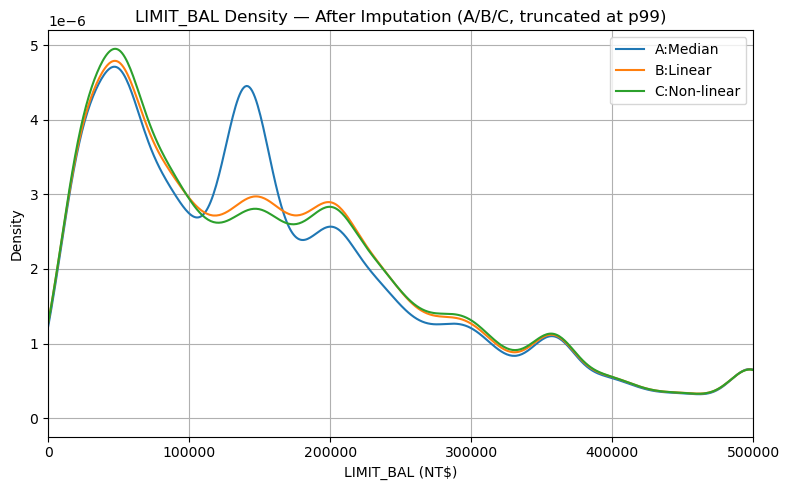

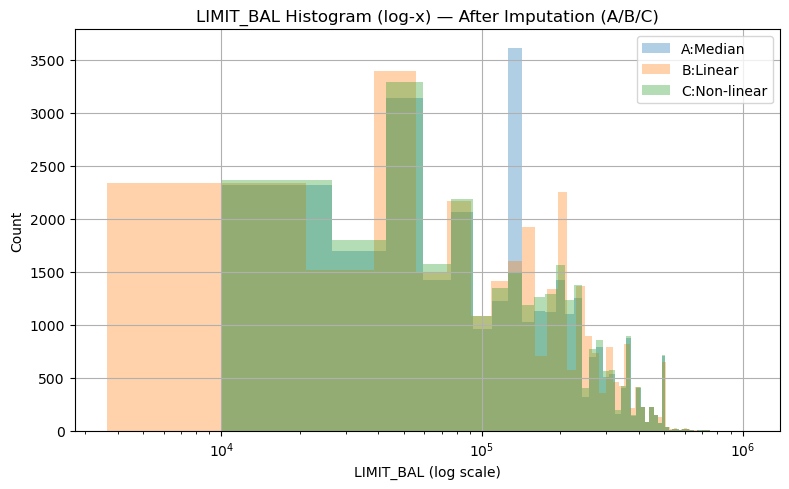

In [ ]:
if "LIMIT_BAL" in A.columns:
    # 99th-percentile cap for clearer densities
    combined = np.concatenate([A["LIMIT_BAL"].values, B["LIMIT_BAL"].values, C["LIMIT_BAL"].values])
    combined = combined[~np.isnan(combined)]
    p99 = np.percentile(combined, 99)

    plt.figure(figsize=(8,5))
    for df_, name in [(A,"A:Median"), (B,"B:Linear"), (C,"C:Non-linear")]:
        s = pd.Series(df_["LIMIT_BAL"]).clip(lower=0)
        s = s[s <= p99]
        if len(s) > 1:
            s.plot(kind="kde", label=name)
    plt.xlim(0, p99)
    plt.xlabel("LIMIT_BAL (NT$)")
    plt.title("LIMIT_BAL Density — After Imputation (A/B/C, truncated at p99)")
    plt.legend(); plt.tight_layout(); plt.show()

    # Log-x histogram to visualize the heavy tail
    plt.figure(figsize=(8,5))
    for df_, name in [(A,"A:Median"), (B,"B:Linear"), (C,"C:Non-linear")]:
        s = pd.Series(df_["LIMIT_BAL"]).clip(lower=0)
        plt.hist(s[s>0], bins=60, alpha=0.35, label=name)
    plt.xscale("log")
    plt.xlabel("LIMIT_BAL (log scale)"); plt.ylabel("Count")
    plt.title("LIMIT_BAL Histogram (log-x) — After Imputation (A/B/C)")
    plt.legend(); plt.tight_layout(); plt.show()


## Part C: Comparative Analysis [20 points]

### 1. Results Comparison [10]

| Model | Method | Accuracy | Precision | Recall | **F1-Score** | ROC-AUC |
|:------|:--------|:---------:|:----------:|:-------:|:-------------:|:---------:|
| **A** | Median Imputation | 0.8097 | 0.6779 | 0.2664 | **0.3825** | 0.7187 |
| **B** | Linear Regression Imputation | 0.8092 | 0.6754 | 0.2646 | **0.3803** | 0.7189 |
| **C** | Non-Linear Regression Imputation | 0.8091 | 0.6743 | 0.2646 | **0.3801** | 0.7185 |
| **D** | Listwise Deletion (train-only) | **0.8164** | **0.7349** | 0.2685 | **0.3933** | **0.7270** |

**Observation:**  
All models show similar performance, with Model D showing a slightly higher F1 (0.39 vs. ~0.38) and Accuracy (~0.81), but the differences are minimal.  
Recall is consistently low (~0.26), indicating class imbalance and that `LIMIT_BAL` has weak influence on the target variable.

---

### 2. Efficacy Discussion [10]

**a) Trade-off: Listwise Deletion (D) vs. Imputation (A, B, C)**  
Model D deletes all rows with missing `LIMIT_BAL`.  
Although it appears slightly better numerically, this is not a genuine improvement — it occurs because removing rows with missing values effectively filters out noisier or harder-to-classify samples.  
In practice, **deletion reduces data size** and introduces bias when the missingness is MAR (Missing At Random).  
Imputation methods retain all samples, which is conceptually superior since they maintain population structure and prevent loss of information.

**b) Linear vs. Non-Linear Regression Imputation**  
Models B (Linear) and C (Non-Linear) gave nearly identical results, suggesting that the relationship between `LIMIT_BAL` and other predictors (`BILL_AMT*`, `PAY_AMT*`, `AGE`) is roughly linear and weakly correlated with the target.  
The KNN (Non-Linear) method did not outperform Linear Regression because the missing column contributes little to model discrimination, and the MAR rate (~5–10%) was too low to highlight non-linear effects.

**c) Recommendation**  
Even though Listwise Deletion showed slightly higher F1, this advantage arises from data bias, not better modeling.  
Under MAR conditions, **imputation methods (A–C)** are preferred:  
- **Linear Regression Imputation (B)** is efficient and interpretable.  
- **Non-Linear KNN Imputation (C)** is suitable when relationships are complex.  
- **Median Imputation (A)** is a robust fallback for fast baseline preprocessing.  

**Final Conclusion:**  
For this dataset, differences across methods are minimal because `LIMIT_BAL` is not a strong predictor.  
However, conceptually, **imputation—especially regression-based—is the correct and statistically sound approach**, while **listwise deletion should be avoided** unless missingness is truly random and negligible.
